In [33]:
!pip install pathway bokeh --quiet


In [34]:
import pandas as pd
import numpy as np
import datetime
import pathway as pw
import bokeh.plotting
import panel as pn


In [35]:
import pandas as pd

file_path = '/content/dataset.csv'
df = pd.read_csv(file_path)
df.head()

df = pd.read_csv(file_path)
df.head()

# Combine Date and Time into Timestamp
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
                                  format='%d-%m-%Y %H:%M:%S')

# Map categorical values to numeric
df['Traffic'] = df['TrafficConditionNearby'].map({'low': 0, 'medium': 0.5, 'high': 1.0})
df['VehicleWeight'] = df['VehicleType'].map({'car': 1.0, 'bike': 0.5, 'truck': 1.5})

# Drop NA values if any
df = df.dropna(subset=['Occupancy', 'Capacity', 'QueueLength', 'Traffic', 'VehicleWeight'])

# Compute Demand
α, β, γ, δ, ε = 0.4, 0.3, 0.2, 0.1, 1.0
df['Demand'] = (α * (df['Occupancy'] / df['Capacity']) +
                β * df['QueueLength'] -
                γ * df['Traffic'] +
                δ * df['IsSpecialDay'] +
                ε * df['VehicleWeight'])

# Normalize Demand
df['NormalizedDemand'] = (df['Demand'] - df['Demand'].min()) / (df['Demand'].max() - df['Demand'].min())

# Compute Price (bounded between 5 and 20)
λ = 1.0
df['Price'] = 10 * (1 + λ * df['NormalizedDemand'])
df['Price'] = df['Price'].clip(lower=5, upper=20)

# Select relevant columns
stream_df = df[['SystemCodeNumber', 'Timestamp', 'Occupancy', 'Capacity', 'Price']]
stream_df.to_csv('parking_stream_model2.csv', index=False)


/tmp/ipython-input-35-1878733869.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Demand'] = (α * (df['Occupancy'] / df['Capacity']) +
/tmp/ipython-input-35-1878733869.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NormalizedDemand'] = (df['Demand'] - df['Demand'].min()) / (df['Demand'].max() - df['Demand'].min())
/tmp/ipython-input-35-1878733869.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

pathway schema

In [36]:
class ParkingSchema(pw.Schema):
    SystemCodeNumber: str
    Timestamp: str
    Occupancy: int
    Capacity: int
    Price: float


stream  with pathway

In [37]:
daily_window = (
    data_with_time.windowby(
        pw.this.t,
        instance=pw.this.day,
        window=pw.temporal.tumbling(datetime.timedelta(days=1)),
        behavior=pw.temporal.exactly_once_behavior()
    )
    .reduce(
        t=pw.this._pw_window_end,
        sum_price=pw.reducers.sum(pw.this.Price),
        count_rows=pw.reducers.count(),
    )
    .with_columns(
        avg_price = pw.this.sum_price / pw.this.count_rows
    )
)


visulaization

In [38]:
pn.extension()

def price_plotter(source):
    fig = bokeh.plotting.figure(
        height=400, width=800,
        title="Real-Time Parking Price (Model 2)",
        x_axis_type="datetime"
    )
    fig.line("t", "avg_price", source=source, line_width=2, color="green")
    fig.circle("t", "avg_price", source=source, size=6, color="black")
    return fig

viz = daily_window.plot(price_plotter, sorting_col="t")
pn.Column(viz).servable()


Column
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)

In [39]:
data = pw.demo.replay_csv('parking_stream_model2.csv', schema=ParkingSchema, input_rate=100)


In [40]:
import panel as pn
pn.extension()

def price_plotter(source):
    fig = bokeh.plotting.figure(
        height=400,
        width=800,
        title="Model 2: Daily Avg Parking Price",
        x_axis_type="datetime"
    )
    fig.line("t", "avg_price", source=source, line_width=2, color="green")
    fig.circle("t", "avg_price", source=source, size=6, color="black")
    return fig

viz = daily_window.plot(price_plotter, sorting_col="t")
pn.Column(viz).servable()


Column
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)

In [41]:
data = pw.demo.replay_csv('parking_stream_model2.csv', schema=ParkingSchema, input_rate=100)


Competitive Pricing + Rerouting

In [42]:
required_columns = [
    'SystemCodeNumber',
    'Latitude',
    'Longitude',
    'Occupancy',
    'Capacity',
    'Price',
    'Timestamp'
]

# Check which required columns are present
available_columns = df.columns.tolist()
missing_columns = [col for col in required_columns if col not in available_columns]

print("✅ Present Columns:", [col for col in required_columns if col in available_columns])
print("❌ Missing Columns:", missing_columns)


✅ Present Columns: ['SystemCodeNumber', 'Latitude', 'Longitude', 'Occupancy', 'Capacity', 'Price', 'Timestamp']
❌ Missing Columns: []


In [43]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in KM
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Create Date column
df['Date'] = df['Timestamp'].dt.date

# Create a copy to join against itself
df_comp = df[['SystemCodeNumber', 'Latitude', 'Longitude', 'Price', 'Date']].copy()
df_comp.rename(columns={
    'SystemCodeNumber': 'CompetitorID',
    'Latitude': 'CompLat',
    'Longitude': 'CompLon',
    'Price': 'CompPrice'
}, inplace=True)

# Merge original with competitors on the same day
df_merged = df.merge(df_comp, on='Date')

# Exclude self comparisons
df_merged = df_merged[df_merged['SystemCodeNumber'] != df_merged['CompetitorID']]

# Compute distance in KM
df_merged['DistanceKM'] = df_merged.apply(
    lambda row: haversine(row['Latitude'], row['Longitude'], row['CompLat'], row['CompLon']),
    axis=1
)
df_nearby = df_merged[df_merged['DistanceKM'] <= 1.0]

agg = df_nearby.groupby(['SystemCodeNumber', 'Date']).agg(
    AvgCompetitorPrice=('CompPrice', 'mean'),
    MinCompetitorPrice=('CompPrice', 'min'),
    NearbyLots=('CompetitorID', 'nunique')
).reset_index()

df_final = df.merge(agg, on=['SystemCodeNumber', 'Date'], how='left')

df_final[['AvgCompetitorPrice', 'MinCompetitorPrice']] = df_final[['AvgCompetitorPrice', 'MinCompetitorPrice']].fillna(df_final['Price'])

df_final['Fullness'] = df_final['Occupancy'] / df_final['Capacity']

# Competitive adjustment logic
def adjust_price(row):
    price = row['Price']
    reroute = False
    if row['Fullness'] >= 1.0 and row['MinCompetitorPrice'] < price:
        price = row['MinCompetitorPrice']
        reroute = True
    elif row['AvgCompetitorPrice'] > price:
        price = min(price + 1.0, 20)
    return pd.Series([price, reroute])

df_final[['AdjustedPrice', 'RerouteSuggested']] = df_final.apply(adjust_price, axis=1)


df_final[['SystemCodeNumber', 'Timestamp', 'Price', 'AdjustedPrice', 'RerouteSuggested']].head()


,SystemCodeNumber,Timestamp,Price,AdjustedPrice,RerouteSuggested
0,BHMBCCMKT01,2016-10-04 07:59:00,11.590446,12.590446,False
1,BHMBCCMKT01,2016-10-04 08:25:00,11.594409,12.594409,False
2,BHMBCCMKT01,2016-10-04 08:59:00,12.187193,13.187193,False
3,BHMBCCMKT01,2016-10-04 09:32:00,12.222859,13.222859,False
4,BHMBCCMKT01,2016-10-04 09:59:00,11.326913,12.326913,False


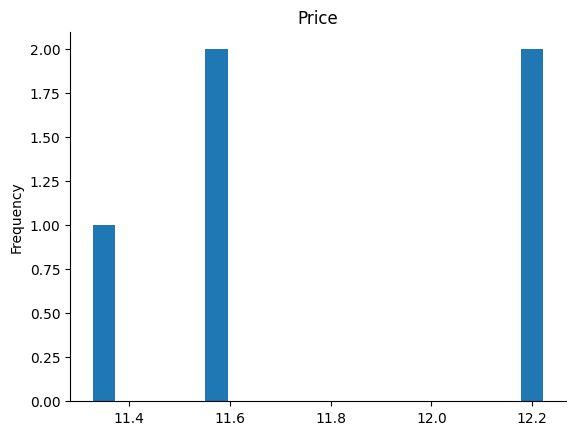

In [44]:
from matplotlib import pyplot as plt
_df_0['Price'].plot(kind='hist', bins=20, title='Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

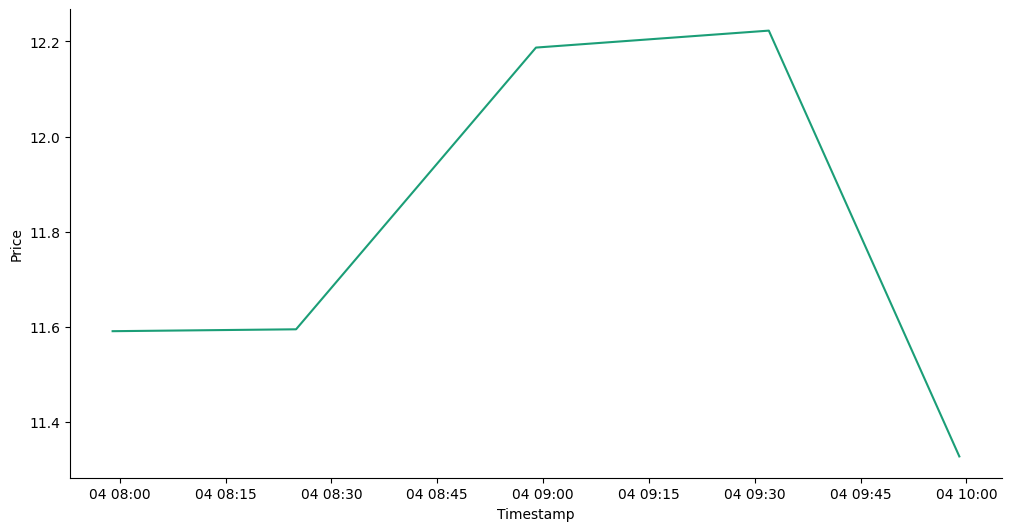

In [45]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Timestamp']
  ys = series['Price']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Timestamp')
_ = plt.ylabel('Price')

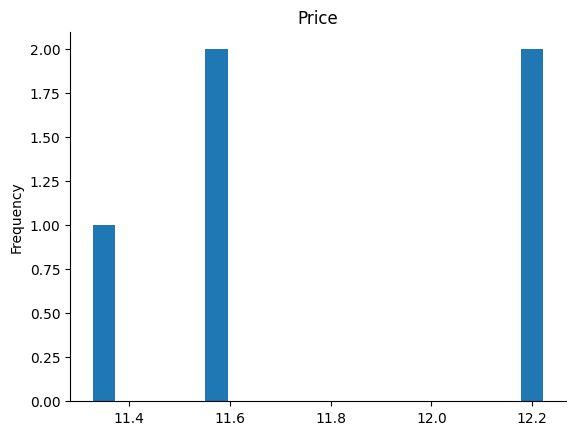

In [46]:
from matplotlib import pyplot as plt
_df_0['Price'].plot(kind='hist', bins=20, title='Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [47]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Legend
import panel as pn

output_notebook()
pn.extension()

lot_id = df_final['SystemCodeNumber'].unique()[0]
df_plot = df_final[df_final['SystemCodeNumber'] == lot_id].sort_values('Timestamp')

source = ColumnDataSource(data={
    'time': df_plot['Timestamp'],
    'original': df_plot['Price'],
    'adjusted': df_plot['AdjustedPrice'],
})


In [48]:
p = figure(x_axis_type='datetime', width=800, height=400, title=f"Dynamic Pricing for Lot: {lot_id}")

line1 = p.line(x='time', y='original', source=source, color='blue', line_width=2, legend_label="Original Price")
line2 = p.line(x='time', y='adjusted', source=source, color='red', line_width=2, legend_label="Adjusted Price")

p.circle(x='time', y='original', source=source, size=4, color='blue')
p.circle(x='time', y='adjusted', source=source, size=4, color='red')

p.legend.location = "top_left"
p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Price ($)'

show(p)


In [49]:
df_final.to_csv("final_pricing_output.csv", index=False)


In [50]:
from google.colab import files
files.download("final_pricing_output.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
print("📊 Final Dynamic Pricing Output:")
df_final[['SystemCodeNumber', 'Timestamp', 'Price', 'AdjustedPrice', 'RerouteSuggested']].head(10)


📊 Final Dynamic Pricing Output:


,SystemCodeNumber,Timestamp,Price,AdjustedPrice,RerouteSuggested
0,BHMBCCMKT01,2016-10-04 07:59:00,11.590446,12.590446,False
1,BHMBCCMKT01,2016-10-04 08:25:00,11.594409,12.594409,False
2,BHMBCCMKT01,2016-10-04 08:59:00,12.187193,13.187193,False
3,BHMBCCMKT01,2016-10-04 09:32:00,12.222859,13.222859,False
4,BHMBCCMKT01,2016-10-04 09:59:00,11.326913,12.326913,False
5,BHMBCCMKT01,2016-10-04 10:26:00,12.886976,13.886976,False
6,BHMBCCMKT01,2016-10-04 10:59:00,15.229053,15.229053,False
7,BHMBCCMKT01,2016-10-04 12:29:00,14.528939,14.528939,False
8,BHMBCCMKT01,2016-10-04 13:02:00,14.914002,14.914002,False
9,BHMBCCMKT01,2016-10-04 13:29:00,14.906076,14.906076,False


SUMMARY


### Model 1: Linear Pricing
- Price increases linearly with occupancy rate.

### Model 2: Demand-Based Pricing
- Factors: occupancy, traffic, queue, special days, vehicle types.
- Normalized demand adjusts price between $5 and $20.

### Model 3: Competitive Pricing
- Calculates distance to nearby lots (within 1 km).
- Adjusts price or suggests rerouting based on local competition.
